In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics
import seaborn as sns
import pickle 


### Get Data



In [2]:
#reading csv file
df = pd.read_csv("./Datasets/fan_0db.csv")
df.shape

(5550, 16)

In [3]:
df.head()

,file_name,y_min,y_max,y_mean,y_std,zcr_mean,zcr_min,zcr_max,spec_cent_min,spec_cent_mean,rms_mean,amp_mean,amp_min,melspec_mean,melspec_std,class
0,Audio_Files/0dB_fan/id_00/abnormal/00000059.wav,-0.032230,0.029817,-6.926849e-07,0.009295,0.031904,0.016113,0.054688,1056.230929,1195.770358,0.009263,0.020296,0.012419,0.020323,0.119019,1
1,Audio_Files/0dB_fan/id_00/abnormal/00000071.wav,-0.034450,0.028665,-6.027881e-07,0.009493,0.021894,0.009766,0.034668,703.965079,800.327823,0.009442,0.020580,0.013375,0.021241,0.128594,1
2,Audio_Files/0dB_fan/id_00/abnormal/00000065.wav,-0.034897,0.028662,5.634240e-06,0.009543,0.027962,0.010742,0.047852,871.776362,998.865525,0.009508,0.020938,0.015119,0.021519,0.125431,1
3,Audio_Files/0dB_fan/id_00/abnormal/00000273.wav,-0.024785,0.026773,5.817374e-07,0.006059,0.057802,0.017578,0.087402,1112.632569,1419.440256,0.006014,0.016007,0.010261,0.008460,0.032597,1
4,Audio_Files/0dB_fan/id_00/abnormal/00000267.wav,-0.034780,0.037046,1.282572e-06,0.004874,0.049731,0.016602,0.279785,771.766407,1154.008254,0.004715,0.012308,0.005732,0.005148,0.024881,1


In [4]:
# drop unnecessary data
df = df.drop(columns = 'file_name')


X = df.drop(columns = 'class')
y = df['class']


In [5]:
count = df['class'].value_counts()
count

0    4075
1    1475
Name: class, dtype: int64

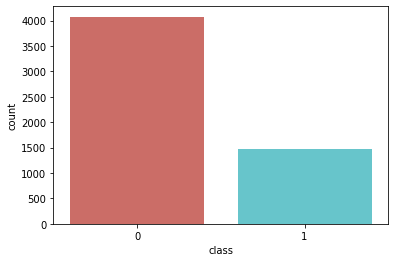

In [6]:
sns.countplot(x='class',data= df, palette= 'hls')
plt.show()


- Abnormal Data Class = 1
- Normal Data Class = 0

### Split Data

In [7]:
# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### Feature Scaling : Standard Scaler

- Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### SVM

- The core idea of SVM is to find a maximum marginal hyperplane(MMH) that best divides the dataset into classes.

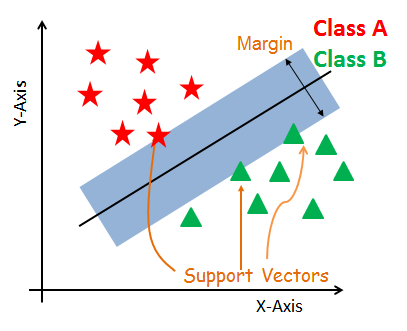

- Support vectors are the data points, which are closest to the hyperplane. These points will define the separating line better by calculating margins. These points are more relevant to the construction of the classifier.

- A margin is a gap between the two lines on the closest class points. This is calculated as the perpendicular distance from the line to support vectors or closest points. If the margin is larger in between the classes, then it is considered a good margin, a smaller margin is a bad margin.

In [9]:
print(f'training set size: {X_train.shape[0]} samples \ntest set size: {X_test.shape[0]} samples')

classifier = svm.SVC(kernel='rbf',probability=True) # radial basis function (RBF)
# Fit the model
classifier.fit(X_train,y_train)

training set size: 4440 samples 
test set size: 1110 samples


SVC(probability=True)

In [10]:
# Predict
y_pred = classifier.predict(X_test)


In [11]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Evaluation of the model

In [12]:
print('Test accuracy for SVM is:',metrics.accuracy_score(y_test,y_pred)*100)

Test accuracy for SVM is: 84.14414414414414


In [13]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
print('\nConfusion matrix:\n',cnf_matrix)


Confusion matrix:
 [[810   6]
 [170 124]]


In [14]:
print('\n Classification Report: \n',metrics.classification_report(y_test,y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.99      0.90       816
           1       0.95      0.42      0.58       294

    accuracy                           0.84      1110
   macro avg       0.89      0.71      0.74      1110
weighted avg       0.86      0.84      0.82      1110



### ROC CURVE

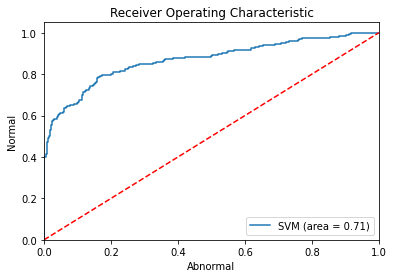

In [15]:
logit_roc_auc = roc_auc_score(y_test, y_pred)

fpr, tpr, thresholds = roc_curve(y_test,classifier.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Abnormal')
plt.ylabel('Normal')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('ROC_Curve_SVM')
plt.show()

In [16]:
def check_overfitting(range_number):
    train_scores, test_scores = list(), list()
    values = [i for i in range(1, range_number)]
    for i in values:
        model = svm.SVC(kernel='rbf',probability=True)
        model.fit(X_train, y_train)
        # train accuracy 
        x_pred = model.predict(X_train)
        train_acc = metrics.accuracy_score(y_train, x_pred)
        train_scores.append(train_acc)
        #test accuracy
        y_pred = model.predict(X_test)
        test_acc = metrics.accuracy_score(y_test, y_pred)
        test_scores.append(test_acc)
        print("{},    Train: {},   Test: {}".format(i, train_acc, test_acc))
        
    plt.plot(values, train_scores, '-o', label='Train')
    plt.plot(values, test_scores, '-o', label='Test')
    plt.legend()
    plt.show()
         

1,    Train: 0.8547297297297297,   Test: 0.8414414414414414
2,    Train: 0.8547297297297297,   Test: 0.8414414414414414
3,    Train: 0.8547297297297297,   Test: 0.8414414414414414
4,    Train: 0.8547297297297297,   Test: 0.8414414414414414
5,    Train: 0.8547297297297297,   Test: 0.8414414414414414
6,    Train: 0.8547297297297297,   Test: 0.8414414414414414
7,    Train: 0.8547297297297297,   Test: 0.8414414414414414
8,    Train: 0.8547297297297297,   Test: 0.8414414414414414
9,    Train: 0.8547297297297297,   Test: 0.8414414414414414


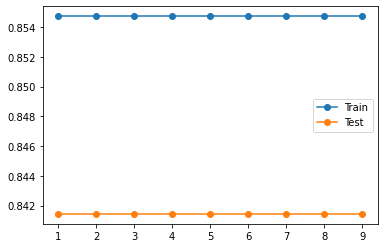

In [17]:

check_overfitting(10)

### Feature Selection

- Variance Threshold Feature Selection
- Univariate Selection using SelectKBest
- Recursive Feature Elimination or RFE
- SelectFromModel
- Sequential Feature Selection or SFS

### Create New Model With Reduces Features

In [18]:
X = df[['y_std', 'rms_mean', 'amp_mean', 'melspec_mean', 'spec_cent_mean']]
y = df['class']

### Split Data

In [19]:
# Split dataset train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


### Feature Scaling : Standard Scaler

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Model

In [21]:
print(f'training set size: {X_train.shape[0]} samples \ntest set size: {X_test.shape[0]} samples')

classifier = svm.SVC(kernel='rbf',probability=True)
# Fit the model
classifier.fit(X_train,y_train)

training set size: 4440 samples 
test set size: 1110 samples


SVC(probability=True)

In [22]:
# Predict
y_pred = classifier.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Evaluation

In [23]:
print('Test accuracy for SVM is:',metrics.accuracy_score(y_test,y_pred)*100)

Test accuracy for SVM is: 83.69369369369369


In [24]:
cnf_matrix = metrics.confusion_matrix(y_test,y_pred)
print('\nConfusion matrix:\n',cnf_matrix)


Confusion matrix:
 [[813   3]
 [178 116]]


In [25]:
print('\n Classification Report: \n',metrics.classification_report(y_test,y_pred))


 Classification Report: 
               precision    recall  f1-score   support

           0       0.82      1.00      0.90       816
           1       0.97      0.39      0.56       294

    accuracy                           0.84      1110
   macro avg       0.90      0.70      0.73      1110
weighted avg       0.86      0.84      0.81      1110



1,    Train: 0.8416666666666667,   Test: 0.8369369369369369
2,    Train: 0.8416666666666667,   Test: 0.8369369369369369
3,    Train: 0.8416666666666667,   Test: 0.8369369369369369
4,    Train: 0.8416666666666667,   Test: 0.8369369369369369
5,    Train: 0.8416666666666667,   Test: 0.8369369369369369
6,    Train: 0.8416666666666667,   Test: 0.8369369369369369
7,    Train: 0.8416666666666667,   Test: 0.8369369369369369
8,    Train: 0.8416666666666667,   Test: 0.8369369369369369
9,    Train: 0.8416666666666667,   Test: 0.8369369369369369


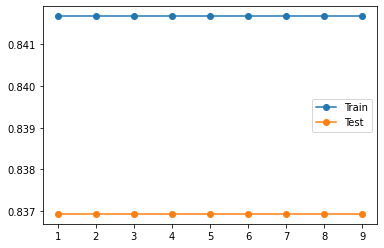

In [27]:
check_overfitting(10)

### Save model


In [ ]:
# save model
filename = 'fan0_Logistic_Regression.sav'
pickle.dump(classifier, open(filename, 'wb'))


In [ ]:
# try model
rf_model = pickle.load(open(filename, 'rb'))


In [ ]:
result = rf_model.predict(X_test)

- SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. It works poorly with overlapping classes and is also sensitive to the type of kernel used.